#  MelodyMaster
## Notebook03 - song2vec & Multiclass
### Idan Kashani & Or Raphael Bidusa

# Shalom again!
Today we will examine another representation of the data - song2vec, based on word2vec representation.
We will use this representation with all sorts of different model, hoping to get a better result than last time with our simple knn.

In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import ast
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
np.random.seed(42)

Loading the dataset and getting the vocabulary.

In [2]:
train_df = pd.read_csv('../train.csv')
print(f'train shape: {train_df.shape}')
train_df['lyrics_as_list'] = train_df['lyrics'].map(lambda l: set(ast.literal_eval(str(l)))) #Why set?
vocabulary = list(sorted(set.union(*train_df['lyrics_as_list'].tolist())))
train_df['lyrics_as_list'] = train_df['lyrics'].map(lambda l: ast.literal_eval(str(l)))
print(f"Vocabulary length is: {len(vocabulary)}")

train shape: (5255, 6)
Vocabulary length is: 46532


In [3]:
with open('../words_list_w2v.txt',encoding='utf-8') as f:
    words = f.read().split('\n')
    # Removing the last word - an empty word
    words.pop()
vectors = np.load('../words_vectors_w2v.npy')

words = [w[3:] if len(w)>3 and w[:3] in ['NN_','VB_','JJ_'] else w for w in words]

for w in words:
    if len(w) > 3:
        if w[:3] == "NN_" or w[:3] == "VB_" or w[:3] == "JJ_":
            print(w)


In [4]:
print(words.count('פסיכותרפיסט'))

2


In [5]:
from collections import defaultdict

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items()
            if len(locs)>1)

dups_indx = [dup for dup in sorted(list_duplicates(words))]
print(f"There are {len(dups_indx)} types with multiple entries")

There are 4123 types with multiple entries


In [6]:
from collections import OrderedDict

words = list(OrderedDict.fromkeys(words))
vectors_without_dups = vectors.copy()
to_delete = []
for d in dups_indx:
    indices = sorted(d[1])
    vectors_without_dups[indices[0]] = np.mean(vectors[indices])
    to_delete = to_delete + indices[1:]
vectors = np.delete(vectors_without_dups, to_delete, 0)

In [7]:
print(len(words))
print(len(vectors))

340419
340419


In [8]:
w2v = dict(zip(words,vectors))
v2w_rep = dict(zip([tuple(v) for v in vectors],words))

In [9]:
def v2w(vector):
    return v2w_rep[tuple(vector)]

ahavti_vec = w2v["אהבתיה"]
print(ahavti_vec)
print(v2w(ahavti_vec))

[-0.047849 -0.237195  0.296635 -0.014212  0.022151  0.172562 -0.081755
  0.131053 -0.049191  0.166546  0.046406  0.112231 -0.065383 -0.154182
  0.11132   0.357974  0.056559 -0.197837  0.122658  0.065558 -0.176146
  0.124626  0.266774 -0.331449  0.055231 -0.08458   0.033744  0.081236
  0.169651  0.221381  0.004441 -0.244207  0.080133  0.244274 -0.09737
 -0.035503  0.162789  0.126568  0.081791 -0.083357  0.059758  0.087832
  0.079024  0.146633  0.105375  0.160128 -0.129235 -0.158333  0.173166
  0.037226 -0.071079  0.01272  -0.014435 -0.002203  0.242982 -0.220937
  0.001111 -0.070437  0.194238  0.162719  0.067988 -0.159687  0.061967
  0.025371 -0.174582  0.178798  0.029152  0.025532  0.016066  0.246695
 -0.056776 -0.389847 -0.053492 -0.16045  -0.321974 -0.153765  0.041302
 -0.010492 -0.284652  0.126697  0.068541  0.001509 -0.023024 -0.059568
  0.10348   0.244634  0.061512 -0.074103  0.096155  0.170907 -0.092507
  0.150437 -0.040386  0.103263  0.153118  0.073103 -0.051595  0.286848
 -0.036

In [10]:
from scipy.spatial import cKDTree
tree = cKDTree(vectors)

def closest_word(vector):
    return words[tree.query(vector, k=1)[1]]

def k_closest_words(vector, k=5):
    distances, close_words = tree.query(vector, k=k)
    return [(words[w], d) for w, d in zip(list(close_words.astype(int)), distances)]

In [11]:
def analogy(x,y,a):
    return w2v[y]-w2v[x]+w2v[a]

In [12]:
print(closest_word(analogy("אנגליה", "לונדון", "צרפת")))
print(closest_word(analogy("מלך", "מלכה", "נסיך")))

פריז
נסיכה


In [13]:
k_closest_words(w2v["גרמניה"],k=14)

[('גרמניה', 0.0),
 ('אוסטריה', 9.436663490929567),
 ('שווייץ', 10.70911817768223),
 ('פרוסיה', 10.974586621357817),
 ('פולין', 11.275983929305372),
 ('הולנד', 11.324757442402465),
 ('צרפת', 11.344306222048795),
 ("צ'כוסלובקיה", 11.5207771481726),
 ('הונגריה', 11.54691985215105),
 ('רוסיה', 11.644340376521805),
 ('פינלנד', 11.71177972528518),
 ('איטליה', 11.92222299772081),
 ('ברלין', 11.978732594655956),
 ('בלגיה', 12.067913401246797)]

In [14]:
def song2vec_mean(song):
    print(len([w for w in song if w in words]))
    return np.mean([w2v[w] for w in song if w in words],axis=0)

def song2vec_max(song):
    return np.max([w2v[w] for w in song if w in words], axis=0)

In [15]:
words_set = set(words)

In [16]:
train_df['song2vec_mean'] = train_df['lyrics_as_list'].map(lambda l: np.mean([w2v[w] for w in l if w in words_set],axis=0))
train_df = train_df.dropna()
train_df['song2vec_max'] = train_df['lyrics_as_list'].map(lambda l: np.max([w2v[w] for w in l if w in words_set],axis=0))

2023-05-03 19:39:50.186477: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-03 19:39:50.213120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 19:39:50.704206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


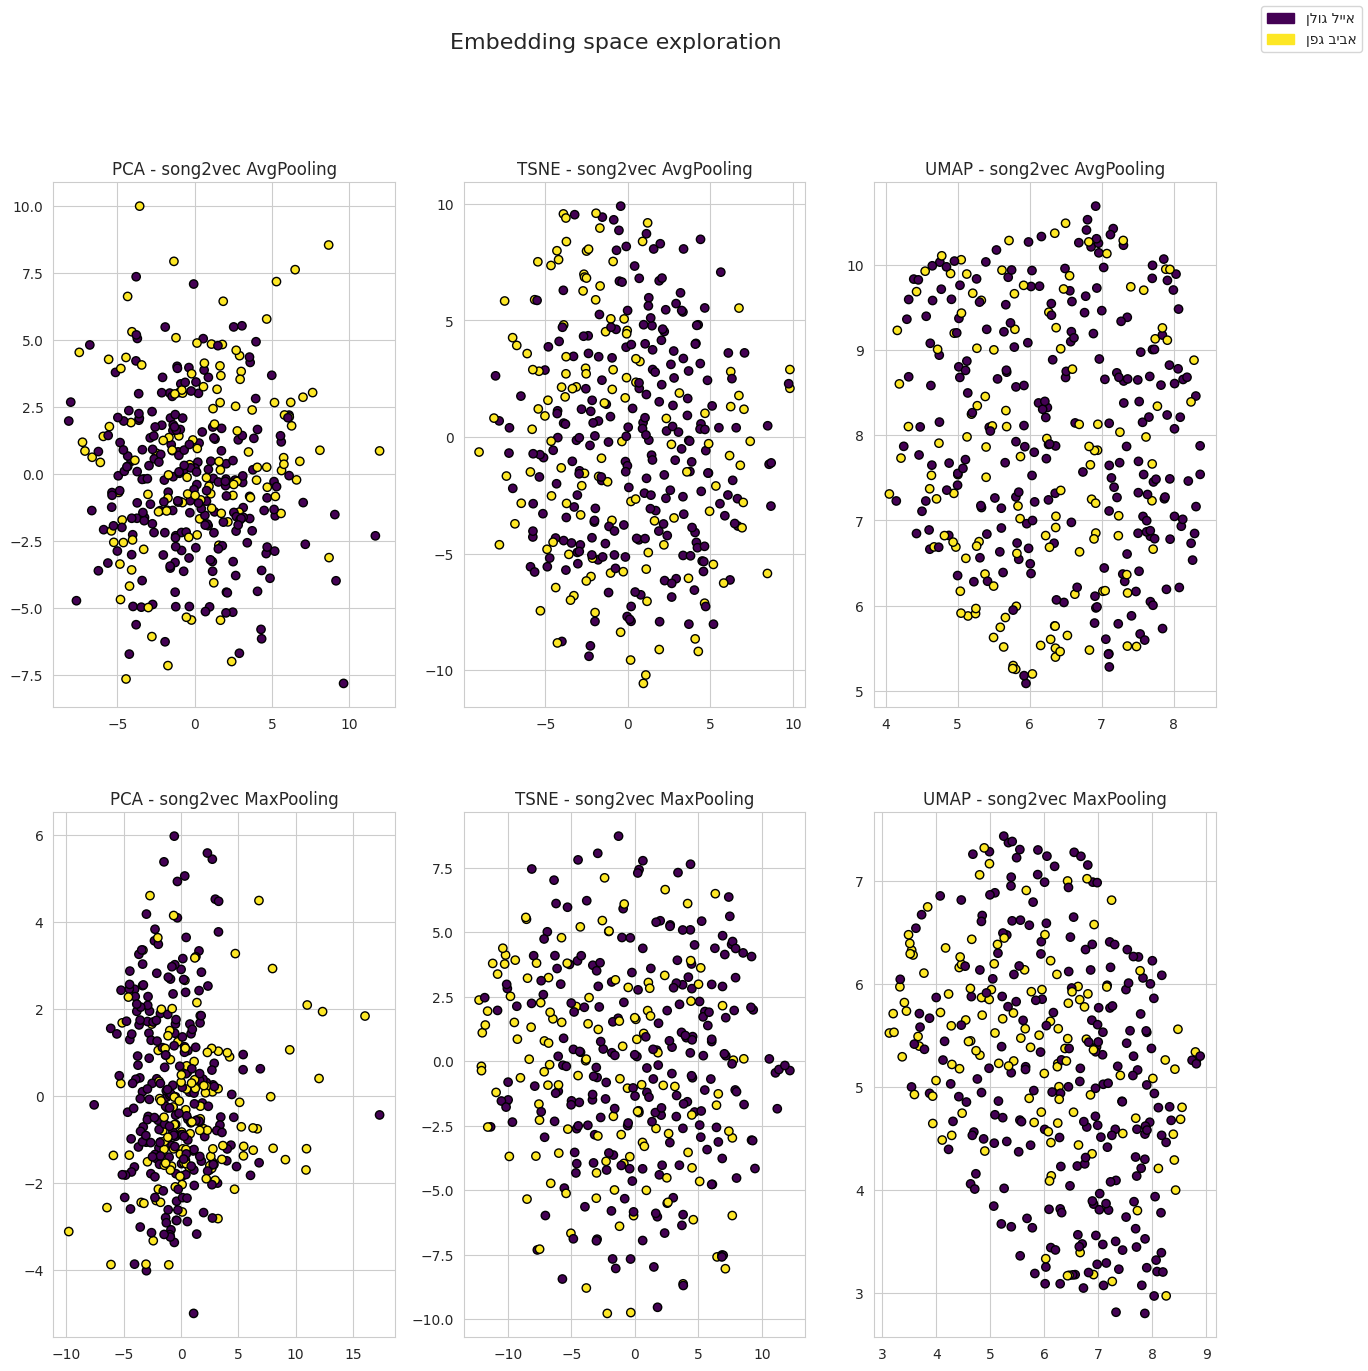

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import patches as mpatches

#artists_to_project = ["אייל גולן", "אביב גפן", "יהודית רביץ"]
artists_to_project = ["אייל גולן", "אביב גפן"]
songs_to_project = train_df['artist'].isin(artists_to_project)
labels = [artists_to_project.index(a) for a in train_df['artist'][songs_to_project]]
cmap = plt.cm.get_cmap('viridis', len(artists_to_project))

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
umap = UMAP(n_components=2)

pca = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
tsne = Pipeline([('scaler', StandardScaler()), ('tsne', tsne)])
umap = Pipeline([('scaler', StandardScaler()), ('umap', umap)])

pca_s2v_mean = pca.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())
tsne_s2v_mean = tsne.fit_transform(np.array(train_df['song2vec_mean'][songs_to_project].to_list()))
umap_s2v_mean = umap.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())

pca_s2v_max = pca.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())
tsne_s2v_max = tsne.fit_transform(np.array(train_df['song2vec_max'][songs_to_project].to_list()))
umap_s2v_max = umap.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())

fig, axes = plt.subplots(2, 3, figsize=(15, 15))
fig.suptitle('Embedding space exploration', fontsize=16)
fig.legend(
    handles=[mpatches.Patch(color=cmap(i), label=artists_to_project[i][::-1]) for i in range(len(artists_to_project))],
    loc='upper right')
axes[0, 0].set_title('PCA - song2vec AvgPooling')
axes[0, 0].scatter(pca_s2v_mean[:, 0], pca_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[0, 1].set_title('TSNE - song2vec AvgPooling')
axes[0, 1].scatter(tsne_s2v_mean[:, 0], tsne_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[0, 2].set_title('UMAP - song2vec AvgPooling')
axes[0, 2].scatter(umap_s2v_mean[:, 0], umap_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')

axes[1, 0].set_title('PCA - song2vec MaxPooling')
axes[1, 0].scatter(pca_s2v_max[:, 0], pca_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[1, 1].set_title('TSNE - song2vec MaxPooling')
axes[1, 1].scatter(tsne_s2v_max[:, 0], tsne_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[1, 2].set_title('UMAP - song2vec MaxPooling')
axes[1, 2].scatter(umap_s2v_max[:, 0], umap_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')

plt.show()

In [18]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

clf = BernoulliNB()

X = np.array(train_df['song2vec_mean'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'alpha': np.logspace(-2, 3, 5)}
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring="f1_micro", n_jobs=-1, verbose=1)
grid.fit(X, y)

print(f"Best params: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'alpha': 56.23413251903491}
Best score: 0.09732824427480917


In [23]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

X = np.array(train_df['song2vec_mean'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'var_smoothing': np.logspace(-9, 5, 30)}
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring="f1_micro", n_jobs=-1, verbose=1)
grid.fit(X, y)

print(f"Best params: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")



Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'var_smoothing': 1e-09}
Best score: 0.08651399491094147


nan

In [20]:
from sklearn.ensemble import AdaBoostClassifier

estimator = GaussianNB()
clf = AdaBoostClassifier(estimator=estimator)

"""
param_grid = {'n_estimators': [500]}

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring="f1_micro", error_score="raise", n_jobs=-1, verbose=3)
grid.fit(X, y)

print(f"Best params: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

"""

from sklearn.model_selection import train_test_split

X = np.array(train_df['song2vec_mean'].to_list())
y = np.array(train_df['artist'].to_list())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))

                precision    recall  f1-score   support

    אבי טולדנו       0.02      0.07      0.03        14
      אביב גפן       0.00      0.00      0.00        27
     אהוד בנאי       0.00      0.00      0.00        18
     אייל גולן       0.21      0.19      0.20        57
        אילנית       0.05      0.05      0.05        20
אריק איינשטיין       0.06      0.17      0.09        53
   ארקדי דוכין       0.00      0.00      0.00        20
        אתניקס       0.00      0.00      0.00        28
      גלי עטרי       0.00      0.00      0.00        16
    דודו אהרון       0.12      0.07      0.09        14
       זהבה בן       0.09      0.09      0.09        34
 חוה אלברשטיין       0.10      0.33      0.16        64
      חיים משה       0.12      0.04      0.06        26
         טיפקס       0.50      0.15      0.24        13
      יגאל בשן       0.08      0.12      0.10        33
  יהודה פוליקר       0.50      0.06      0.11        17
   יהודית רביץ       0.00      0.00      0.00  

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = grid.predict(X)
print(classification_report(y, y_pred))
#print(confusion_matrix(y, y_pred))

                precision    recall  f1-score   support

    אבי טולדנו       0.07      0.02      0.03       102
      אביב גפן       0.19      0.06      0.09       126
     אהוד בנאי       0.07      0.26      0.11        89
     אייל גולן       0.14      0.13      0.13       238
        אילנית       0.25      0.07      0.11        97
אריק איינשטיין       0.26      0.05      0.09       276
   ארקדי דוכין       0.10      0.19      0.13        80
        אתניקס       0.16      0.12      0.14       152
      גלי עטרי       0.17      0.05      0.07       105
    דודו אהרון       0.10      0.62      0.17        94
       זהבה בן       0.12      0.07      0.09       154
 חוה אלברשטיין       0.22      0.06      0.10       346
      חיים משה       0.08      0.04      0.05       101
         טיפקס       0.21      0.14      0.17        85
      יגאל בשן       0.17      0.02      0.04       168
  יהודה פוליקר       0.19      0.10      0.13        81
   יהודית רביץ       0.12      0.09      0.11  

In [22]:
from xgboost import XGBClassifier

clf = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.1, n_jobs=-1)

"""
param_grid = {}
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring="f1_micro", error_score="raise", n_jobs=-1, verbose=3)
grid.fit(X, y)

print(f"Best params: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")
"""

from sklearn.model_selection import train_test_split

X = np.array(train_df['song2vec_mean'].to_list())
y = np.array(train_df['artist'].to_list())

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=3)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

AttributeError: 'bool' object has no attribute 'all'

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(max_depth=2, n_estimators=100, learning_rate=0.1, n_jobs=-1)

"""
param_grid = {}
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring="f1_micro", error_score="raise", n_jobs=-1, verbose=3)
grid.fit(X, y)

print(f"Best params: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")
"""

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=3)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1: {f1_score(y_test, y_pred, average='micro')}")



In [ ]:
train_df["artist"].value_counts()